In [1]:
import os
import random
import time
from dataclasses import dataclass
import copy

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter

from goal_task import GoalTask

@dataclass
class Args:
    exp_name: str = 'TD3'
    """the name of this experiment"""
    seed: int = 22
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "MoA_ESN_wandb"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = False
    """whether to save model into the `runs/{run_name}` folder"""
    upload_model: bool = False
    """whether to upload the saved model to huggingface"""
    hf_entity: str = ""
    """the user or org name of the model repository from the Hugging Face Hub"""

    #Environment specific arguments
    goal_change = False
    test = False
    initial_positions = None

    # Algorithm specific arguments
    env_id: str = "GoalChange"
    """the id of the environment"""
    total_timesteps: int = 120000
    """total timesteps of the experiments"""
    learning_rate: float = 3e-4
    """the learning rate of the optimizer"""
    buffer_size: int = 2048
    """the replay memory buffer size"""
    gamma: float = 0.95
    """the discount factor gamma"""
    tau: float = 0.05
    """target smoothing coefficient (default: 0.005)"""
    batch_size: int = 64
    """the batch size of sample from the reply memory"""
    policy_noise: float = 0.2
    """the scale of policy noise"""
    exploration_noise: float = 0.1
    """the scale of exploration noise"""
    learning_starts: int = 2500
    """timestep to start learning"""
    policy_frequency: int = 2
    """the frequency of training policy (delayed)"""
    noise_clip: float = 0.5
    """noise clip parameter of the Target Policy Smoothing Regularization"""


def make_env(env_id, seed, idx, capture_video, run_name, initial_position=None):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = GoalTask(initial_position = initial_position)
        env.action_space.seed(seed)
        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc_mu = nn.Linear(32, np.prod(env.action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias
    
def inference(actor, args, global_step, external_noise=False):
    trajectory = []
    for initial_postion in args.initial_positions:
        inference_env = make_env(args.env_id, args.seed, 0, args.capture_video, run_name, initial_position=initial_postion)()
        if global_step < args.total_timesteps/2:
            inference_env.change_goal((15,10))
        elif global_step >= args.total_timesteps/2:
            inference_env.change_goal((5,10))
        obs, _ = inference_env.reset() 
        inference_actor = copy.deepcopy(actor)
        while True:
            with torch.no_grad():
                action = inference_actor(torch.Tensor(obs).to(device))
                if external_noise:
                    actions += torch.normal(0, actor.action_scale * args.exploration_noise)
                action = action.cpu().numpy()
                next_obs, reward, termination, truncated, info = inference_env.step(action)
                if termination:
                    break
                obs = next_obs
        trajectory.append(inference_env.get_trajectory())
        inference_env.close()
    return trajectory

In [2]:
import stable_baselines3 as sb3

if sb3.__version__ < "2.0":
    raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1"
"""
        )

args = Args()
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

In [3]:
# env setup
envs = make_env(args.env_id, args.seed, 0, args.capture_video, run_name)()
envs.change_goal((15,10))

actor = Actor(envs).to(device)
qf1 = QNetwork(envs).to(device)
qf2 = QNetwork(envs).to(device)
qf1_target = QNetwork(envs).to(device)
qf2_target = QNetwork(envs).to(device)
target_actor = Actor(envs).to(device)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
qf2_target.load_state_dict(qf2.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()) + list(qf2.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.observation_space.dtype = np.float32
rb = ReplayBuffer(
    args.buffer_size,
    envs.observation_space,
    envs.action_space,
    device,
    handle_timeout_termination=False,
)
start_time = time.time()

### TRAIN

In [4]:
# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)
all_trajectory = {}
for global_step in range(args.total_timesteps):
    # CHANGE GOAL        
    if global_step >= args.total_timesteps/2:
        envs.change_goal((5,10))

    # INFERENCE:
    if global_step % 8000 == 0 or global_step == args.total_timesteps-1:
        args.initial_positions = [(2,2), (2,10), (2,18), (10,2), (10,18), (18,2), (18,10), (18,18)]
        trajectory = inference(actor, args, global_step)
        all_trajectory[f'{global_step}'] = trajectory

    # ALGO LOGIC: put action logic here
    if global_step < args.learning_starts:
        actions = envs.action_space.sample()
    else:
        with torch.no_grad():
            actions = actor(torch.Tensor(obs).to(device))
            actions += torch.normal(0, actor.action_scale * args.exploration_noise)
            actions = actions.cpu().numpy().clip(envs.action_space.low, envs.action_space.high)

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if "final_info" in infos or terminations:
        print(f"global_step={global_step}, episodic_return={infos['episode']['r']}")
        writer.add_scalar("charts/episodic_return", infos["episode"]["r"], global_step)
        writer.add_scalar("charts/episodic_length", infos["episode"]["l"], global_step)     

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    if truncations:
        real_next_obs = infos["final_observation"]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        with torch.no_grad():
            clipped_noise = (torch.randn_like(data.actions, device=device) * args.policy_noise).clamp(
                -args.noise_clip, args.noise_clip
            ) * target_actor.action_scale

            next_state_actions = (target_actor(data.next_observations) + clipped_noise).clamp(
                envs.action_space.low[0], envs.action_space.high[0]
            )
            qf1_next_target = qf1_target(data.next_observations, next_state_actions)
            qf2_next_target = qf2_target(data.next_observations, next_state_actions)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (min_qf_next_target).view(-1)

        qf1_a_values = qf1(data.observations, data.actions).view(-1)
        qf2_a_values = qf2(data.observations, data.actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        # optimize the model
        q_optimizer.zero_grad()
        qf_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:
            actor_loss = -qf1(data.observations, actor(data.observations)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # update the target network
            for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf2.parameters(), qf2_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)

        if global_step % 100 == 0:
            writer.add_scalar("losses/qf1_values", qf1_a_values.mean().item(), global_step)
            writer.add_scalar("losses/qf2_values", qf2_a_values.mean().item(), global_step)
            writer.add_scalar("losses/qf1_loss", qf1_loss.item(), global_step)
            writer.add_scalar("losses/qf2_loss", qf2_loss.item(), global_step)
            writer.add_scalar("losses/qf_loss", qf_loss.item() / 2.0, global_step)
            writer.add_scalar("losses/actor_loss", actor_loss.item(), global_step)
envs.close()
writer.close()

global_step=199, episodic_return=-0.47000000000000025
global_step=399, episodic_return=-0.09999999999999999
global_step=599, episodic_return=0
global_step=799, episodic_return=-0.13999999999999999
global_step=999, episodic_return=-0.21000000000000005
global_step=1199, episodic_return=0
global_step=1399, episodic_return=-0.07
global_step=1503, episodic_return=1
global_step=1603, episodic_return=0.91
global_step=1803, episodic_return=-0.19000000000000003
global_step=2003, episodic_return=-0.22000000000000006
global_step=2203, episodic_return=-0.2900000000000001
global_step=2403, episodic_return=-0.12999999999999998
global_step=2603, episodic_return=-1.1000000000000008
global_step=2803, episodic_return=-1.8900000000000015
global_step=3003, episodic_return=-1.290000000000001
global_step=3009, episodic_return=1
global_step=3209, episodic_return=-1.7900000000000014
global_step=3409, episodic_return=-0.8300000000000005
global_step=3439, episodic_return=1
global_step=3452, episodic_return=1
gl

KeyboardInterrupt: 

C:\Users\24401\AppData\Local\Temp\ipykernel_1152\3793109000.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


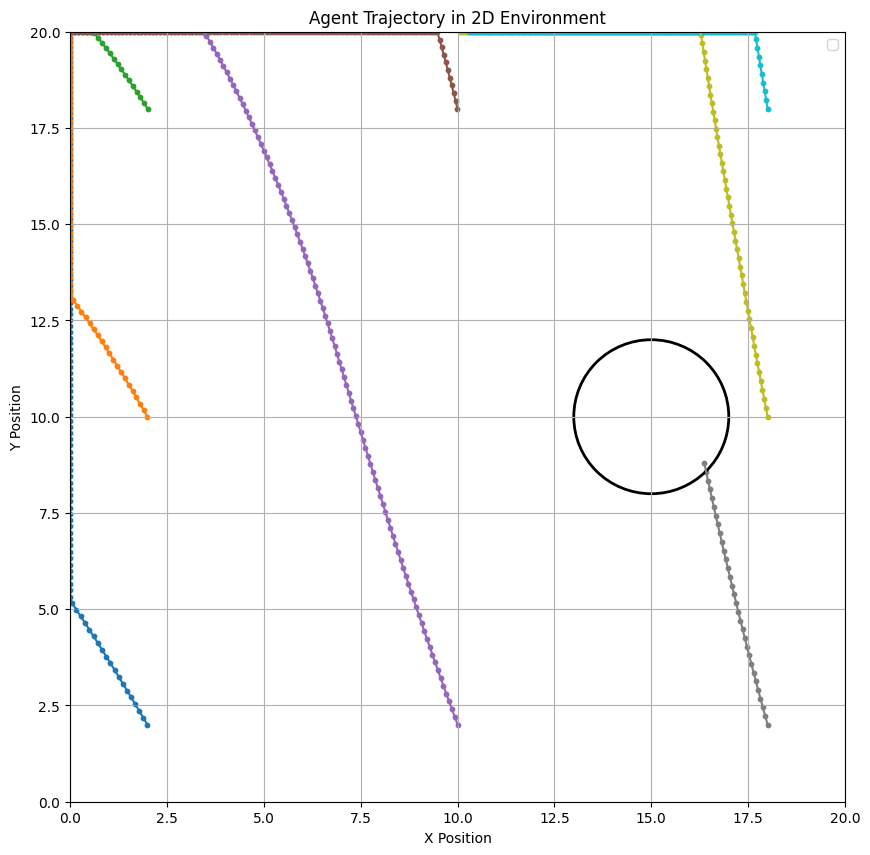

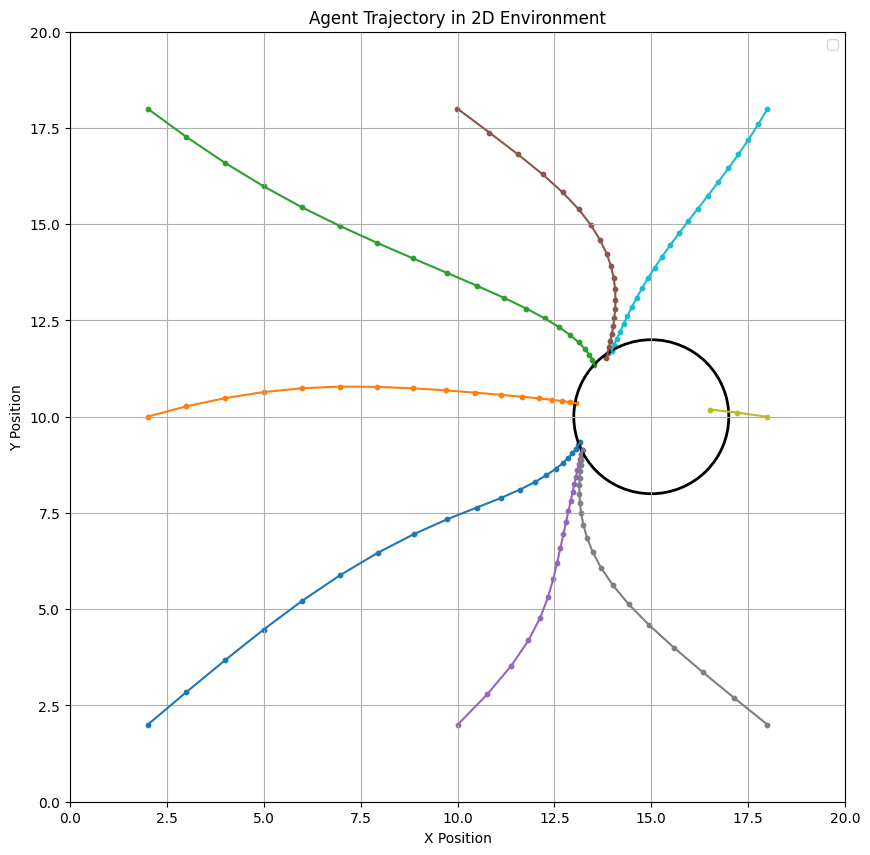

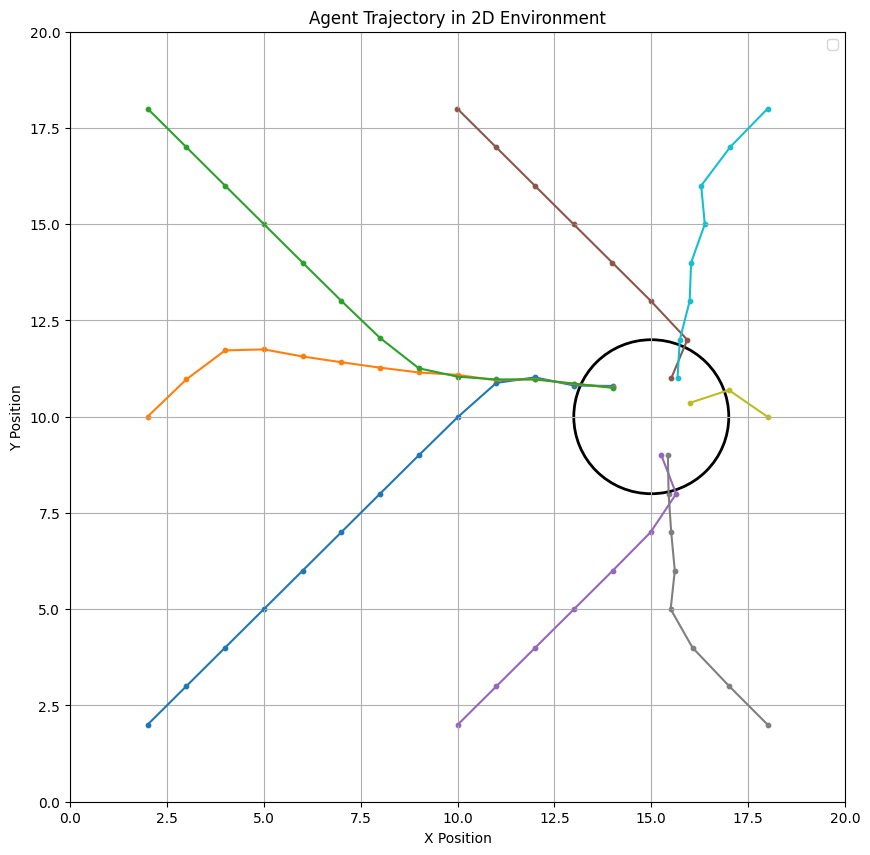

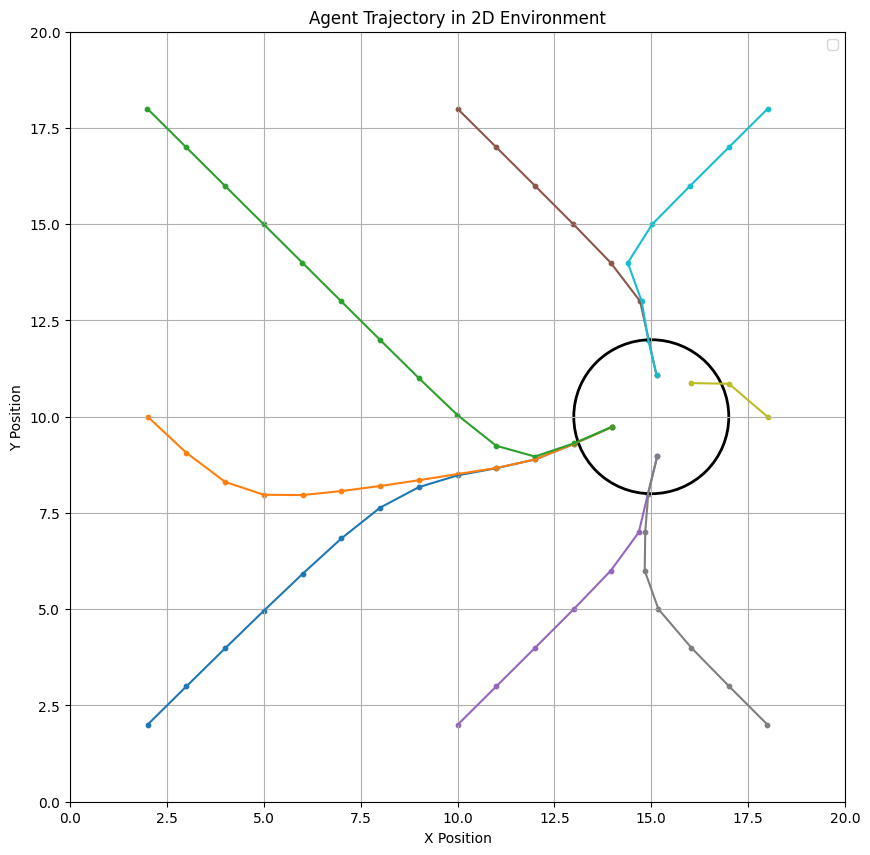

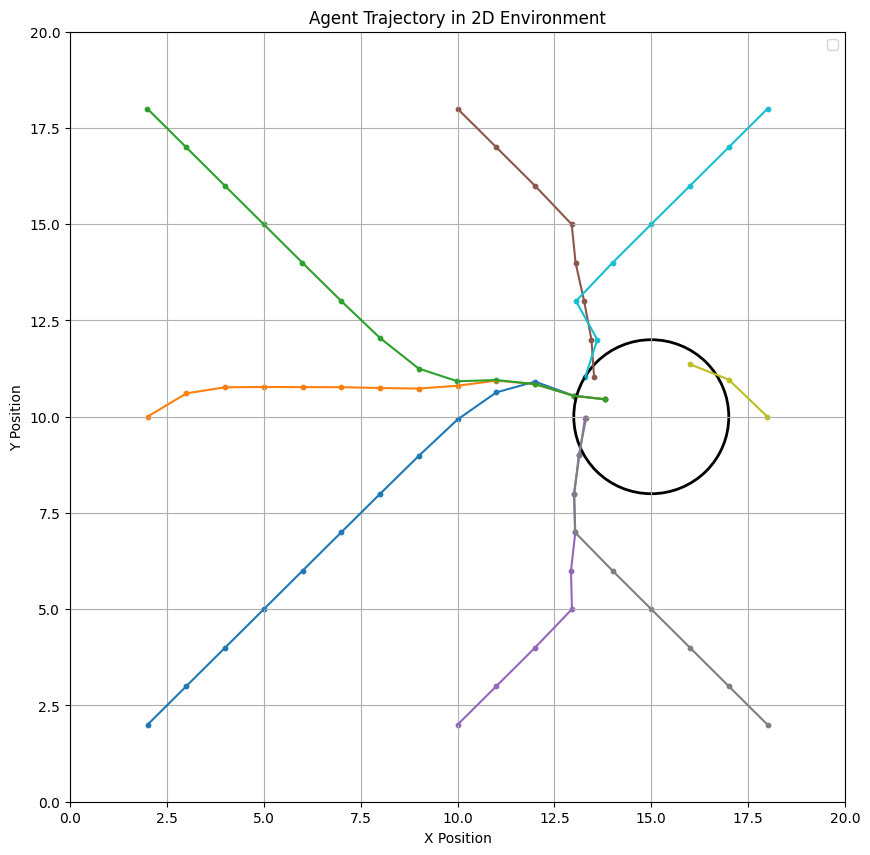

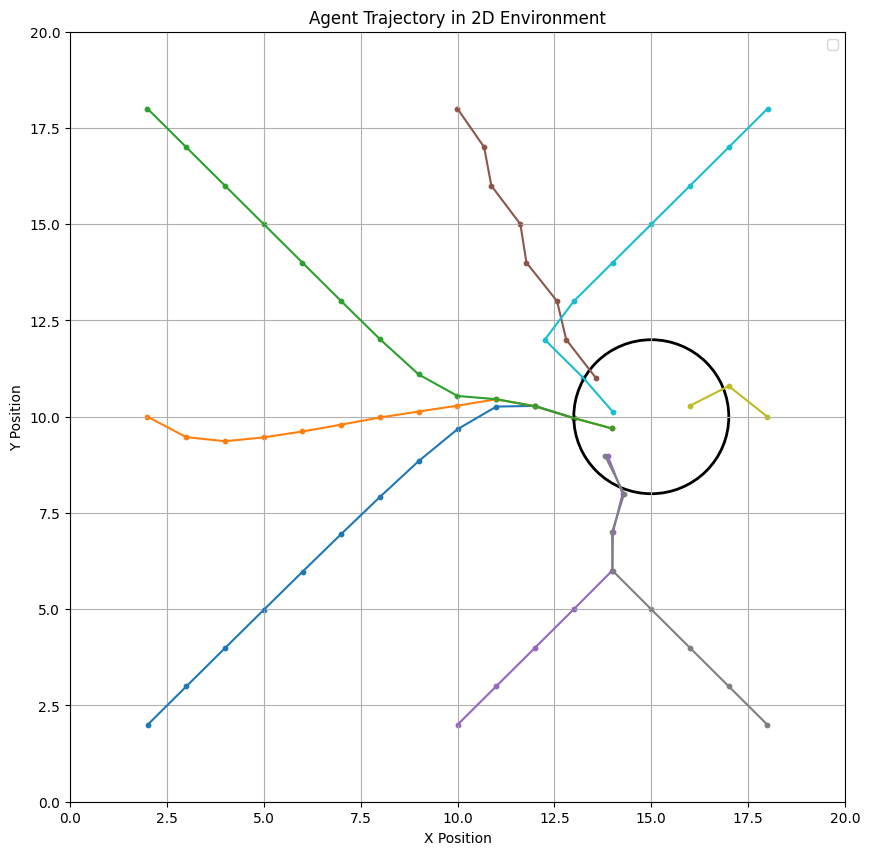

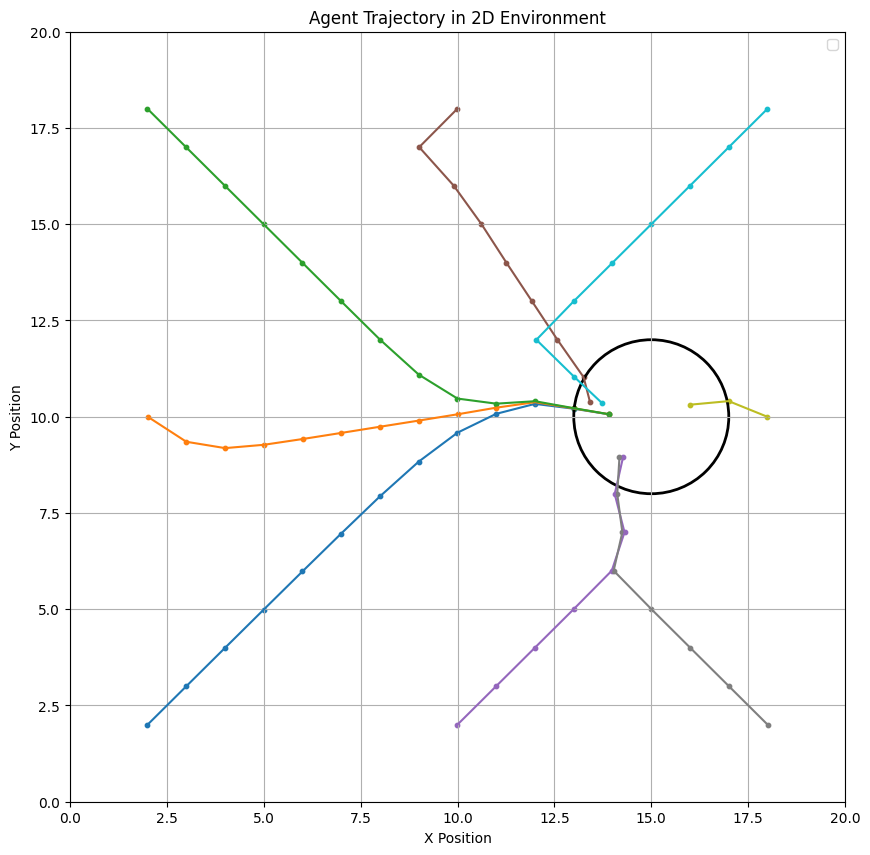

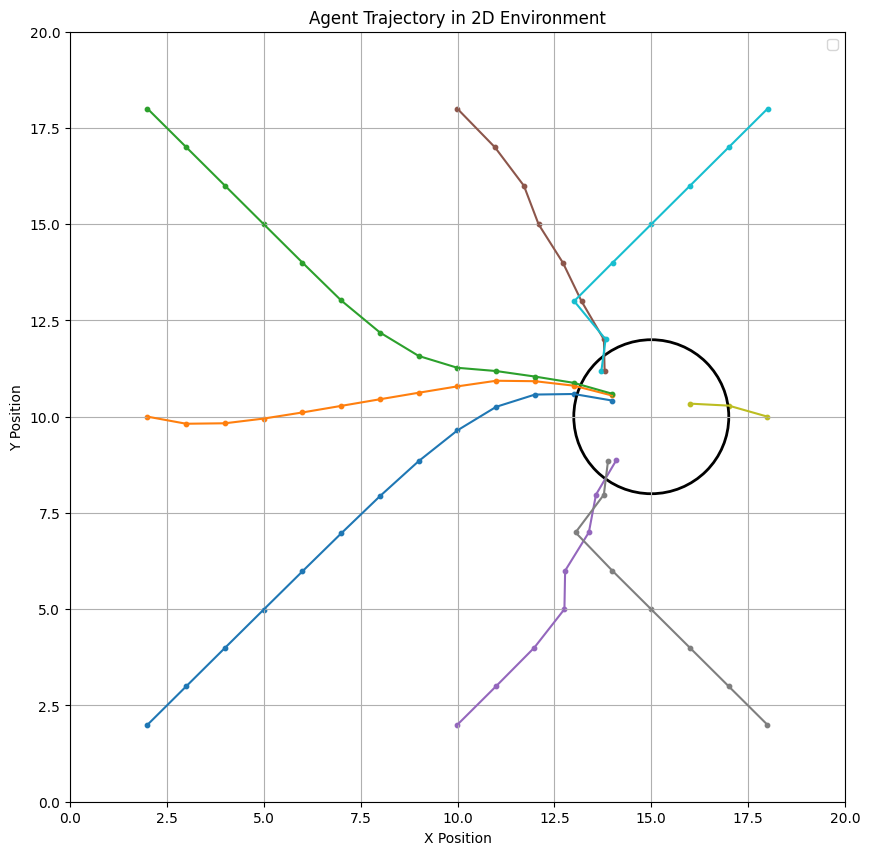

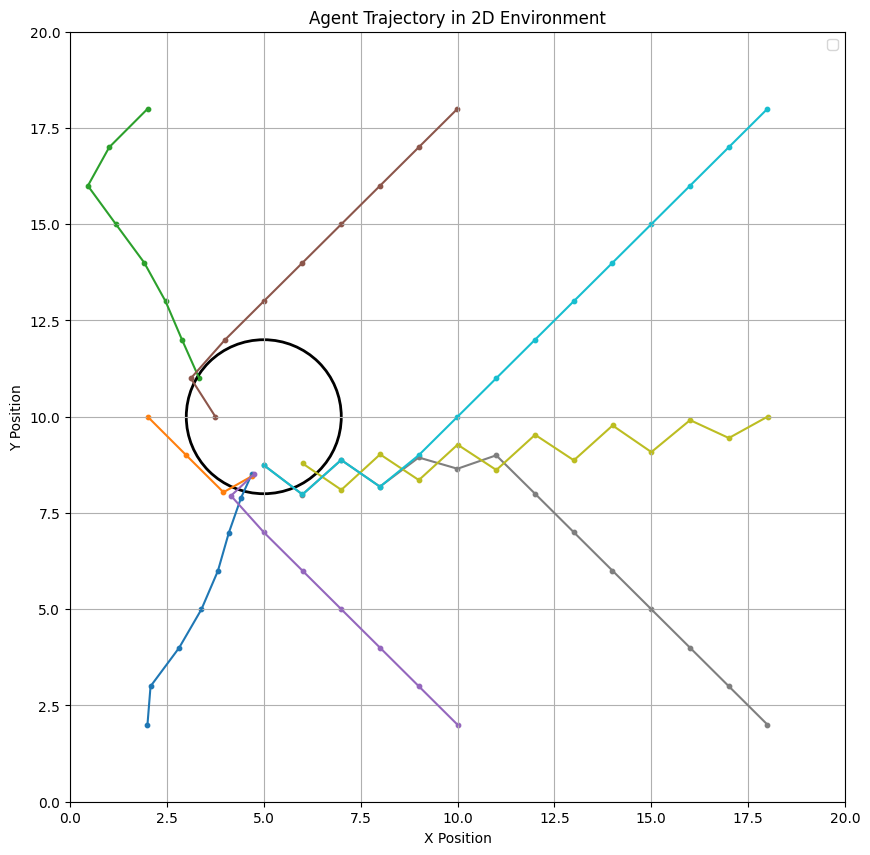

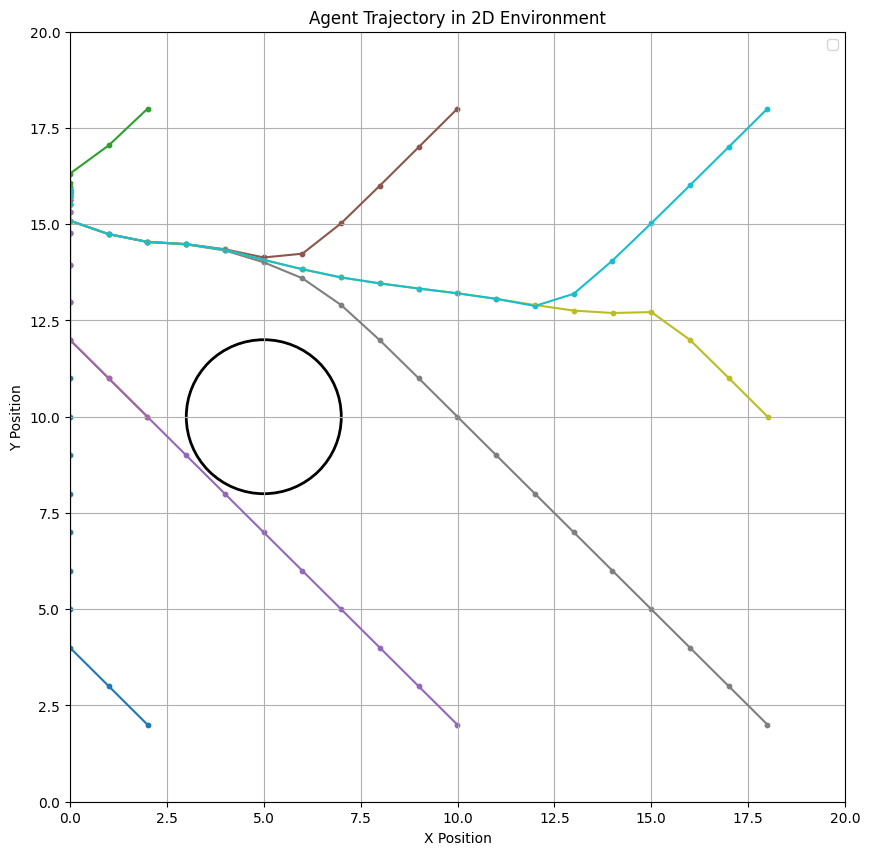

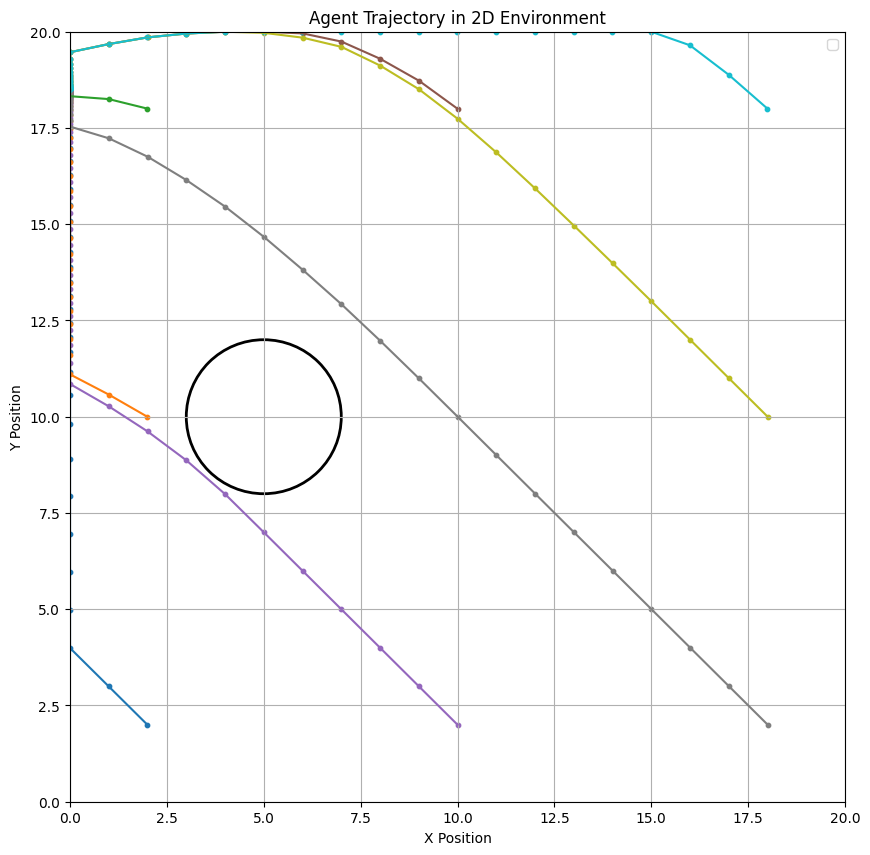

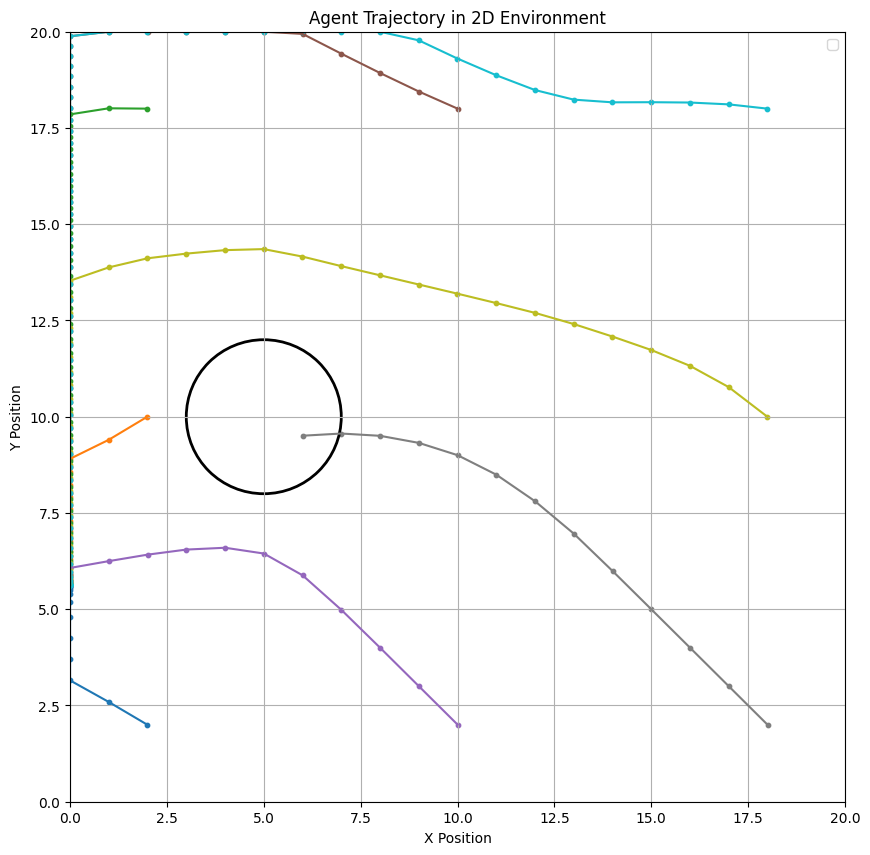

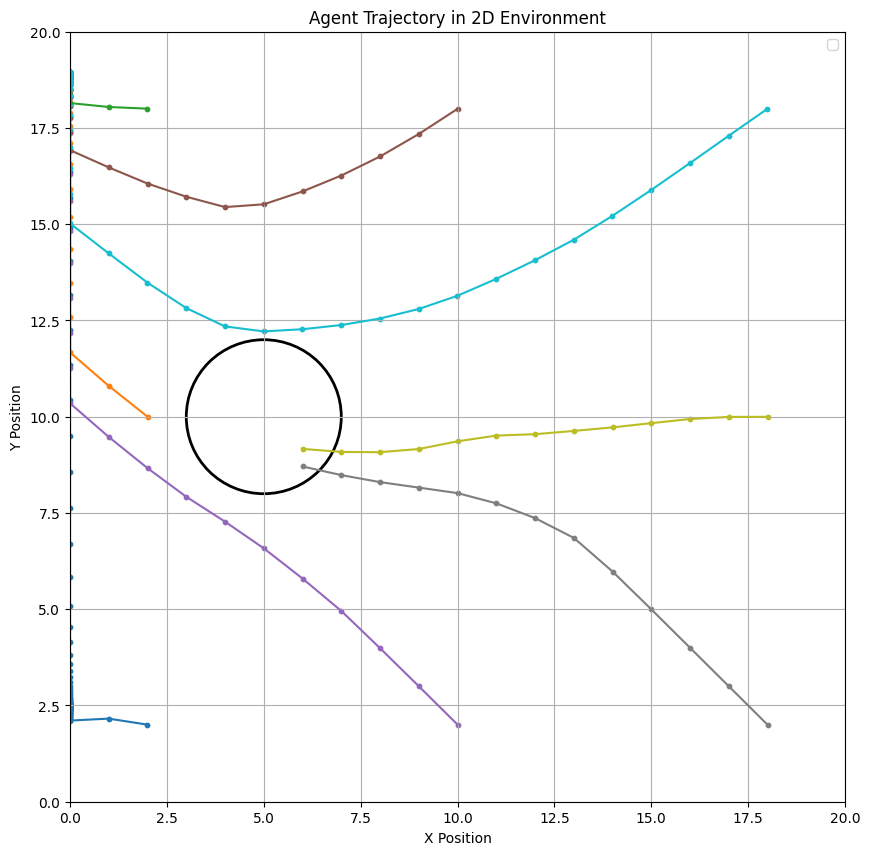

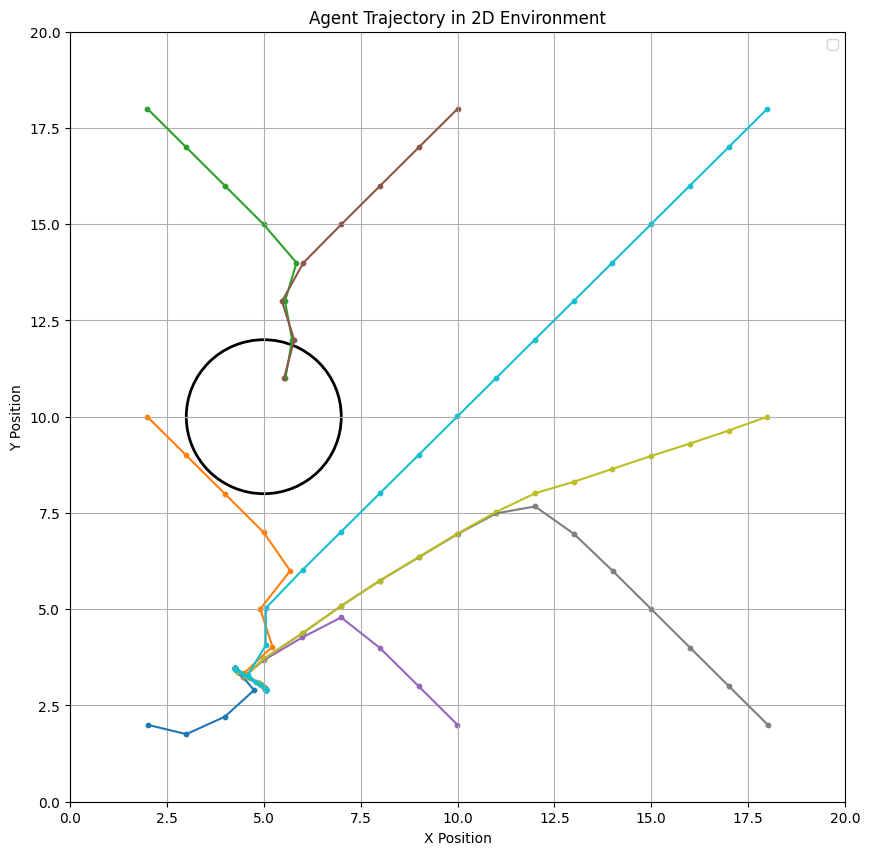

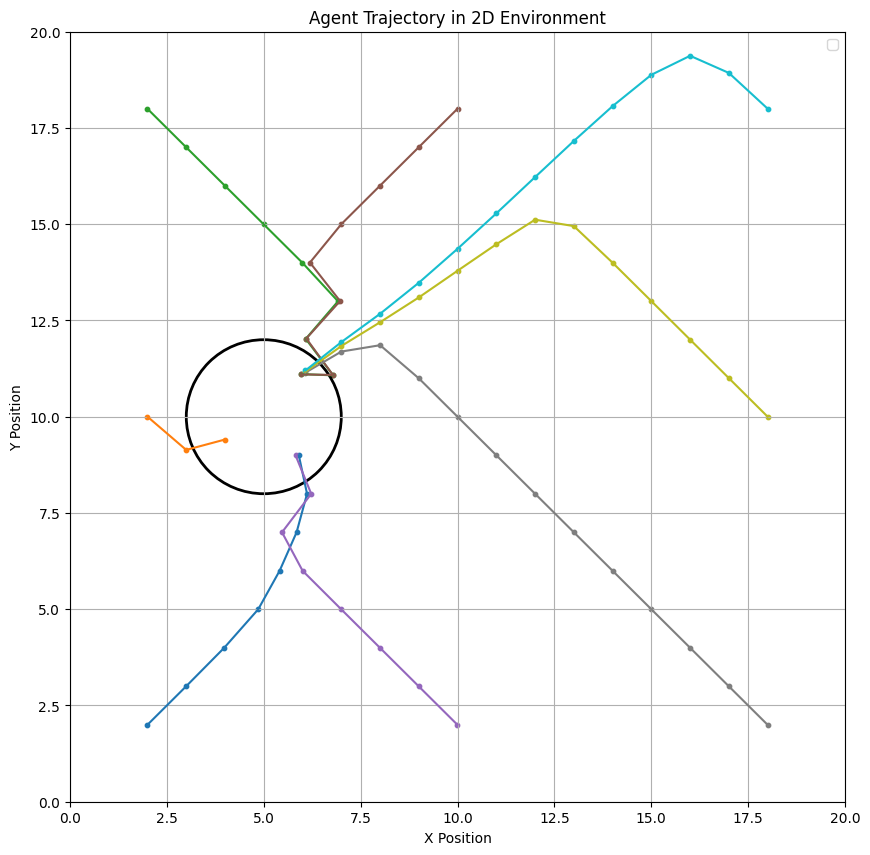

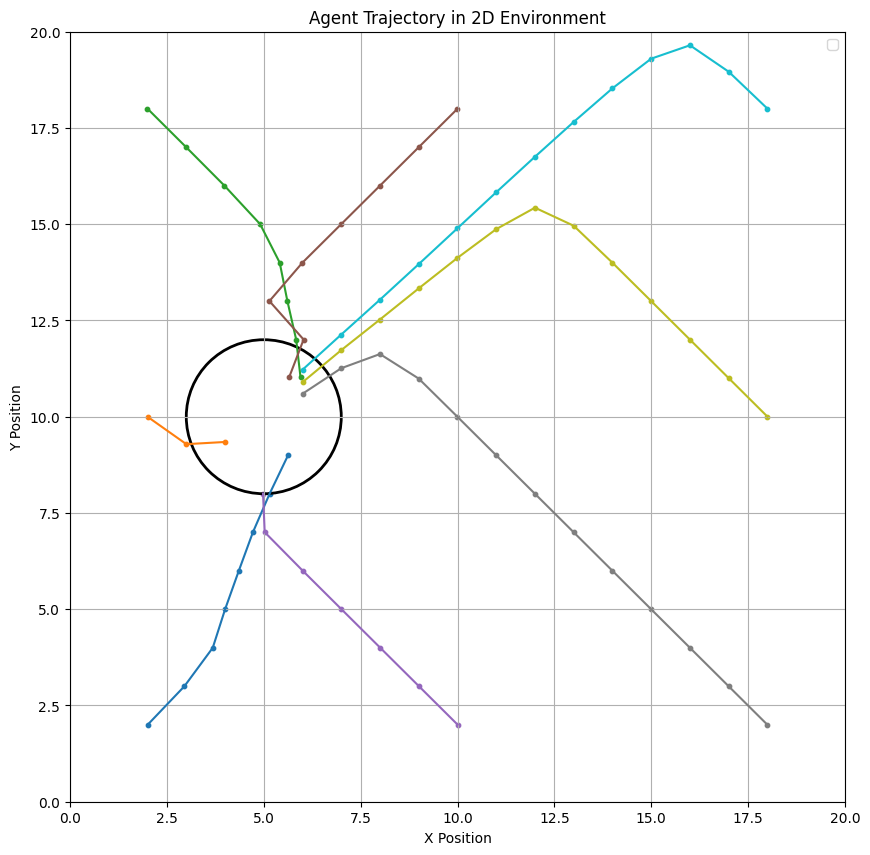

In [23]:
import matplotlib.pyplot as plt
fig_dir = f'runs/{run_name}/figures'
os.makedirs(fig_dir, exist_ok=True)
for trajectories in all_trajectory:
    step = int(trajectories)
    trajectories = all_trajectory[f'{trajectories}']
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    for i, (trajectory, color) in enumerate(zip(trajectories, colors)):
        ax.plot(trajectory[:, 0], trajectory[:, 1], color=color)
        ax.scatter(trajectory[:, 0], trajectory[:, 1], color=color, s=10)
    if step < args.total_timesteps/2:
        circle = plt.Circle((15, 10), radius=2, color='black', fill=False, linestyle='-', linewidth=2)
    elif step >= args.total_timesteps/2:
        circle = plt.Circle((5, 10), radius=2, color='black', fill=False, linestyle='-', linewidth=2)
    ax.add_patch(circle)
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Agent Trajectory in 2D Environment')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{fig_dir}/{step}.png')